In [130]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

import pyrsm as rsm

%load_ext autoreload
%autoreload 2
from src.get_model_performance import fdr, get_average_performance
# fdr = make_scorer(greater_is_better=True, needs_proba=False)
# from metrics import FDR
from sklearn.model_selection import train_test_split

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [219]:
pd.set_option('display.max_rows', 100)

## Load data

In [2]:
IT = pd.read_pickle("ready_for_inference_data/IT.pickle")
OOT = pd.read_pickle("ready_for_inference_data/OOT.pickle")
top_30_features = pd.read_csv("ready_for_inference_data/FS choices-Top 30.csv", usecols=[1], names=["feature"], skiprows=1)

In [3]:
# Separate prediction labels from features
y_IT, y_OOT = IT.pop("Fraud"), OOT.pop("Fraud")

# Only keep the previously identified top 30 features
IT = IT[top_30_features.feature]
OOT = OOT[top_30_features.feature]

In [4]:
""" As Prof instructed on slide 42 of Class 9.pptx, 
calculate z-scale stats using IT + OOT data """

scaler = StandardScaler().fit(pd.concat([IT, OOT], axis=0))

IT_z_scaled = scaler.transform(IT)
OOT_z_scaled = scaler.transform(OOT)

## Define FDR scoring function

In [5]:
fdr_score = make_scorer(fdr, greater_is_better=True, needs_proba=True, perc=3.)

## Logistic regression

In [6]:
lr_param_grid = {
    "C": [1e-2, 1e-1, 1.],
    "penalty": ["l1", "l2"],
    "solver": ["saga"],  # default lbfgs doesn't work with l1 penalty
    "max_iter": [300],  # default of 100 triggers non-convergence warning
}

In [7]:
%%time

perf_df = get_average_performance(
    X_trn_tst = IT_z_scaled,
    y_trn_tst = y_IT,
    X_oot = OOT_z_scaled,
    y_oot = y_OOT,
    clf = LogisticRegression(),
    model_name = "lr",
    param_grid = lr_param_grid,
    scoring = fdr_score,
    splitter_random_state = 924,                 
    test_size = 0.3,
)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not 

CPU times: user 1min 24s, sys: 2.04 s, total: 1min 27s
Wall time: 3min


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [8]:
perf_df.sort_values(by="lr_mean_test_fdr", ascending=False)

,C,max_iter,penalty,solver,lr_mean_train_fdr,lr_mean_test_fdr,lr_oot_fdr
3,0.10,300,l2,saga,0.569922,0.559575,0.497191
4,1.00,300,l1,saga,0.569924,0.559564,0.497191
5,1.00,300,l2,saga,0.569923,0.559105,0.505618
2,0.10,300,l1,saga,0.563923,0.555878,0.449438
1,0.01,300,l2,saga,0.563350,0.553158,0.471910
0,0.01,300,l1,saga,0.536184,0.536303,0.494382


## Random Forest

In [34]:
rf_param_grid = {
    "n_estimators": [30, 100, 150],
    "max_depth": [10, 20, 30],
    "min_samples_split": [2, 8, 16],
    "min_samples_leaf": [1, 3, 5],
    "random_state": [1234] 
}

In [35]:
%%time

perf_df = get_average_performance(
    X_trn_tst = IT_z_scaled,
    y_trn_tst = y_IT,
    X_oot = OOT_z_scaled,
    y_oot = y_OOT,
    clf = RandomForestClassifier(),
    model_name = "rf",
    param_grid = rf_param_grid,
    scoring = fdr_score,
    splitter_random_state = 924,                 
    test_size = 0.3,
)

CPU times: user 41min 30s, sys: 2.03 s, total: 41min 32s
Wall time: 1h 27min 51s


In [37]:
perf_df.sort_values(by="rf_mean_test_fdr", ascending=False)

,max_depth,min_samples_leaf,min_samples_split,n_estimators,random_state,rf_mean_train_fdr,rf_mean_test_fdr,rf_oot_fdr
55,30,1,2,100,1234,1.000000,0.852470,0.603933
56,30,1,2,150,1234,1.000000,0.850505,0.601124
29,20,1,2,150,1234,1.000000,0.843576,0.598315
28,20,1,2,100,1234,1.000000,0.843254,0.595506
54,30,1,2,30,1234,1.000000,0.841117,0.609551
...,...,...,...,...,...,...,...,...
3,10,1,8,30,1234,0.966749,0.785265,0.601124
21,10,5,8,30,1234,0.936051,0.784816,0.606742
18,10,5,2,30,1234,0.936051,0.784816,0.606742
6,10,1,16,30,1234,0.957528,0.783159,0.595506


## MLP

In [25]:
mlp_param_grid = {
    "hidden_layer_sizes": [(5,), (20,20)],
    "learning_rate_init": [0.001, 0.01, 0.05],
    "random_state": [1234] ,
    "max_iter": [50, 100, 200],
    "early_stopping":[True,False]
}

In [26]:
%%time

perf_df = get_average_performance(
    X_trn_tst = IT_z_scaled,
    y_trn_tst = y_IT,
    X_oot = OOT_z_scaled,
    y_oot = y_OOT,
    clf = MLPClassifier(),
    model_name = "mlp",
    param_grid = mlp_param_grid,
    scoring = fdr_score,
    splitter_random_state = 924,                 
    test_size = 0.3,
)

/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:614:

CPU times: user 11min 5s, sys: 3min 21s, total: 14min 27s
Wall time: 20min 49s


In [27]:
perf_df.sort_values(by="mlp_mean_test_fdr", ascending=False)

,early_stopping,hidden_layer_sizes,learning_rate_init,max_iter,random_state,mlp_mean_train_fdr,mlp_mean_test_fdr,mlp_oot_fdr
32,False,"(20, 20)",0.010,200,1234,0.890746,0.774555,0.438202
29,False,"(20, 20)",0.001,200,1234,0.898033,0.773863,0.398876
31,False,"(20, 20)",0.010,100,1234,0.886988,0.772290,0.438202
30,False,"(20, 20)",0.010,50,1234,0.856541,0.762950,0.457865
28,False,"(20, 20)",0.001,100,1234,0.847013,0.757488,0.401685
27,False,"(20, 20)",0.001,50,1234,0.787486,0.735981,0.421348
35,False,"(20, 20)",0.050,200,1234,0.741527,0.712124,0.570225
34,False,"(20, 20)",0.050,100,1234,0.741527,0.712124,0.570225
12,True,"(20, 20)",0.010,50,1234,0.720851,0.683764,0.547753
14,True,"(20, 20)",0.010,200,1234,0.720851,0.683764,0.547753


## Gradient Boosting

In [31]:
gb_param_grid = {
    "n_estimators": [300, 500],
    "max_depth": [3, 4, 5],
    "learning_rate":[0.001, 0.01, 0.1],
    "random_state": [1234] 
}

In [32]:
%%time

perf_df = get_average_performance(
    X_trn_tst = IT_z_scaled,
    y_trn_tst = y_IT,
    X_oot = OOT_z_scaled,
    y_oot = y_OOT,
    clf = GradientBoostingClassifier(),
    model_name = "gb",
    param_grid = gb_param_grid,
    scoring = fdr_score,
    splitter_random_state = 924,                 
    test_size = 0.3,
)

CPU times: user 1h 48min 33s, sys: 2.96 s, total: 1h 48min 36s
Wall time: 3h 54min 14s


In [33]:
perf_df.sort_values(by="gb_mean_test_fdr", ascending=False)

,learning_rate,max_depth,n_estimators,random_state,gb_mean_train_fdr,gb_mean_test_fdr,gb_oot_fdr
17,0.100,5.0,500.0,1234.0,1.000000,0.841422,0.505618
16,0.100,5.0,300.0,1234.0,1.000000,0.830384,0.491573
15,0.100,4.0,500.0,1234.0,0.999794,0.827315,0.466292
13,0.100,3.0,500.0,1234.0,0.994860,0.821985,0.491573
14,0.100,4.0,300.0,1234.0,0.999597,0.820496,0.449438
12,0.100,3.0,300.0,1234.0,0.967545,0.809894,0.491573
11,0.010,5.0,500.0,1234.0,0.917146,0.799044,0.558989
10,0.010,5.0,300.0,1234.0,0.858538,0.769002,0.533708
9,0.010,4.0,500.0,1234.0,0.851549,0.755021,0.612360
8,0.010,4.0,300.0,1234.0,0.778637,0.709618,0.598315


## Profit Savings Plot

## Final Model

In [9]:
param = {
    "learning_rate": 0.001,
    "max_depth": 4,
    "n_estimators": 500,
    "random_state": 1234
}

clf = GradientBoostingClassifier(**param)

In [103]:
def get_per_split_stats(df: pd.DataFrame, percentile: int) -> pd.DataFrame:
    num_records = df.shape[0]
    num_bads = df.y_true.sum()
    num_goods = num_records - num_bads
    perc_goods = num_goods / num_records * 100
    perc_bads = num_bads / num_records * 100
    
    return pd.DataFrame({
        "# Records": [num_records],
        "# Goods": [num_goods],
        "# Bads": [num_bads],
        "% Goods": [perc_goods],
        "% Bads": [perc_bads]
    }, index=pd.Series(int(percentile), name="percentile"))


def get_cum_stats(result_df):
    result_df = result_df.copy()
    result_df['Total # Records'] = result_df['# Records'].cumsum()
    result_df['Cumulative Good'] = result_df['# Goods'].cumsum()
    result_df['Cumulative Bad'] = result_df['# Bads'].cumsum()
    result_df['Cumulative % Good'] = 100 * result_df['Cumulative Good'] / result_df['Cumulative Good'].iloc[-1]
    result_df['Cumulative % Bad'] = 100 * result_df['Cumulative Bad'] / result_df['Cumulative Bad'].iloc[-1]
    result_df = result_df.assign(
        KS = result_df["Cumulative % Bad"] - result_df["Cumulative % Good"],
        FPR = result_df['Cumulative Good'] / result_df['Cumulative Bad']
    )
    return result_df

### Train test split

In [45]:
X_train, X_test, y_train, y_test = train_test_split(IT_z_scaled, y_IT, test_size=0.3, random_state=1234)

### Result on Training Set

In [12]:
# clf = clf.fit(X_train, y_train)

In [62]:
train_df = pd.DataFrame(X_train, columns=IT.columns)
train_df["y_pred"] = clf.predict_proba(X_train)[:, 1]
train_df["y_true"] = [y for y in y_train]

,card_merch_total_3,card_merch_total_14,card_zip_total_7,card_merch_total_30,card_merch_max_14,card_zip_total_30,card_merch_max_30,card_zip_max_30,card_zip_max_3,card_state_max_14,...,merch_state_avg_1,Cardnum_avg_14,merch_zip_avg_1,Cardnum_avg_30,Cardnum_med_0,merch_zip_avg_3,merch_state_avg_3,Cardnum_max_3,y_pred,y_true
48322,-0.158923,-0.185747,-0.182388,-0.211862,-0.405094,-0.229450,-0.422345,-0.441401,-0.388995,-0.469556,...,-0.452967,0.373354,-0.450502,0.145119,-0.432510,-0.462970,-0.466184,-0.525930,0.006993,0
48323,0.465645,0.422159,0.423032,0.376844,1.729897,0.344470,1.652847,1.614633,1.795838,1.336174,...,0.155367,-0.079069,0.154279,-0.110311,-0.370397,0.159871,0.160778,0.990353,0.008016,0
48324,-0.013932,-0.044624,-0.041842,0.099632,-0.247389,0.074221,-0.269057,-0.289529,-0.227608,-0.336173,...,-0.451699,-0.287541,-0.449242,-0.004635,-0.408370,-0.456867,-0.460040,-0.123460,0.007304,0
48325,0.245782,0.335407,0.209910,0.292831,0.252496,0.262568,0.216826,0.191869,0.283947,0.086619,...,-0.131802,-0.073862,-0.131213,-0.089388,-0.280862,-0.134146,-0.135184,1.986045,0.008016,0
48326,-0.026615,-0.056969,-0.054136,-0.087151,0.134621,-0.107871,0.102253,0.078354,0.163320,-0.013077,...,-0.091509,-0.353250,-0.091155,-0.383990,-0.516949,-0.092892,-0.093658,-0.162550,0.007304,0
48327,-0.157245,-0.184114,-0.180762,-0.210282,-0.398253,-0.227909,-0.415695,-0.434813,-0.381993,-0.463770,...,-0.443095,-0.629259,-0.440688,-0.034336,-0.422088,-0.452863,-0.456010,-0.521324,0.006993,0
48328,0.083496,0.050205,0.052599,0.480338,0.008166,0.445365,0.444090,0.417035,0.033913,-0.120029,...,-0.276519,0.590647,-0.275085,0.845908,-0.346171,-0.245340,-0.247114,-0.247690,0.008016,0
48329,-0.158832,-0.065491,-0.134031,-0.095405,-0.167672,-0.115918,-0.191573,-0.212760,-0.388617,0.179666,...,-0.452435,0.102597,-0.449974,0.011904,-0.431948,-0.056811,-0.057337,-0.525682,0.006993,0
48330,-0.165265,0.156858,-0.072904,0.140512,0.506965,0.114074,0.464168,0.436927,-0.415472,0.301844,...,-0.216463,-0.006855,-0.215379,-0.011197,-0.491276,-0.284744,-0.286778,-0.512951,0.006993,0
48331,-0.055370,0.164817,-0.082010,0.266385,0.105563,0.236785,0.074010,0.050371,0.043284,-0.037653,...,0.156535,0.047046,0.155441,-0.202230,0.210958,0.161067,0.161982,-0.241525,0.006993,0


In [64]:
train_df = train_df.sort_values('y_pred', ascending=False)

In [65]:
splitted_train_df = np.array_split(train_df, 100, axis=0)

In [84]:
train_result = pd.concat([
    get_per_split_stats(splitted_train_df[p], percentile=p+1)
    for p in range(100)
])

display(train_result.round(2))

,# Records,# Goods,# Bads,% Goods,% Bads
percentile,,,,,
1,484,210,274,43.39,56.61
2,484,446,38,92.15,7.85
3,484,476,8,98.35,1.65
4,484,472,12,97.52,2.48
5,484,479,5,98.97,1.03
...,...,...,...,...,...
96,483,483,0,100.00,0.00
97,483,483,0,100.00,0.00
98,483,483,0,100.00,0.00


In [104]:
best_model_train_result = get_cum_stats(train_result).round(2).iloc[:20]
best_model_train_result.to_csv("best_model_train_result.csv")

### Result on Test Set

In [96]:
test_df = pd.DataFrame(X_test, columns=IT.columns)
test_df["y_pred"] = clf.predict_proba(X_test)[:, 1]
test_df["y_true"] = [y for y in y_test]

In [97]:
test_df = test_df.sort_values('y_pred', ascending=False)
splitted_test_df = np.array_split(test_df, 100, axis=0)

In [98]:
test_result = pd.concat([
    get_per_split_stats(splitted_test_df[p], percentile=p+1)
    for p in range(100)
])

display(test_result.round(2))

,# Records,# Goods,# Bads,% Goods,% Bads
percentile,,,,,
1,208,82,126,39.42,60.58
2,208,193,15,92.79,7.21
3,208,201,7,96.63,3.37
4,208,201,7,96.63,3.37
5,208,204,4,98.08,1.92
...,...,...,...,...,...
96,207,207,0,100.00,0.00
97,207,206,1,99.52,0.48
98,207,206,1,99.52,0.48


In [105]:
best_model_test_result = get_cum_stats(test_result).round(2).iloc[:20]
best_model_test_result.to_csv("best_model_test_result.csv")

display(best_model_test_result)

,# Records,# Goods,# Bads,% Goods,% Bads,Total # Records,Cumulative Good,Cumulative Bad,Cumulative % Good,Cumulative % Bad,KS,FPR
percentile,,,,,,,,,,,,
1,208,82,126,39.42,60.58,208,82,126,0.40,54.78,54.38,0.65
2,208,193,15,92.79,7.21,416,275,141,1.34,61.30,59.96,1.95
3,208,201,7,96.63,3.37,624,476,148,2.32,64.35,62.02,3.22
4,208,201,7,96.63,3.37,832,677,155,3.31,67.39,64.09,4.37
5,208,204,4,98.08,1.92,1040,881,159,4.30,69.13,64.83,5.54
6,208,207,1,99.52,0.48,1248,1088,160,5.31,69.57,64.25,6.80
7,208,207,1,99.52,0.48,1456,1295,161,6.32,70.00,63.68,8.04
8,208,207,1,99.52,0.48,1664,1502,162,7.33,70.43,63.10,9.27
9,208,204,4,98.08,1.92,1872,1706,166,8.33,72.17,63.85,10.28


### Result on OOT Set

In [122]:
oot_df

array([[-0.03025164, -0.06050849, -0.05766162, ...,  0.31243453,
         0.31435067, -0.17253882],
       [-0.09330721, -0.12188195, -0.11878411, ..., -0.06755502,
        -0.06815271, -0.34571922],
       [-0.16887891, -0.12286952, -0.11976764, ..., -0.43839384,
        -0.44144482,  0.29527731],
       ...,
       [-0.09016601, -0.11882455, -0.11573921, ...,  1.46136898,
         1.47088591,  0.10964599],
       [ 0.33571853,  0.29569884,  0.29708909, ...,  1.44054773,
         1.44992692,  0.83258827],
       [-0.00717914, -0.03805149,  0.67035619, ..., -0.22027676,
        -0.22188478,  1.43095137]])

In [123]:
oot_df = pd.DataFrame(OOT_z_scaled, columns=OOT.columns)
oot_df["y_pred"] = clf.predict_proba(OOT_z_scaled)[:, 1]
oot_df["y_true"] = [y for y in y_OOT]

oot_df = oot_df.sort_values('y_pred', ascending=False)
splitted_oot_df = np.array_split(oot_df, 100, axis=0)

In [124]:
oot_result = pd.concat([
    get_per_split_stats(splitted_oot_df[p], percentile=p+1)
    for p in range(100)
])

display(oot_result.round(2))

,# Records,# Goods,# Bads,% Goods,% Bads
percentile,,,,,
1,274,161,113,58.76,41.24
2,274,216,58,78.83,21.17
3,274,248,26,90.51,9.49
4,274,265,9,96.72,3.28
5,274,262,12,95.62,4.38
...,...,...,...,...,...
96,273,273,0,100.00,0.00
97,273,273,0,100.00,0.00
98,273,273,0,100.00,0.00


In [125]:
best_model_oot_result = get_cum_stats(oot_result).round(2).iloc[:20]
best_model_oot_result.to_csv("best_model_oot_result.csv")
display(best_model_oot_result)

,# Records,# Goods,# Bads,% Goods,% Bads,Total # Records,Cumulative Good,Cumulative Bad,Cumulative % Good,Cumulative % Bad,KS,FPR
percentile,,,,,,,,,,,,
1,274,161,113,58.76,41.24,274,161,113,0.60,31.74,31.15,1.42
2,274,216,58,78.83,21.17,548,377,171,1.40,48.03,46.64,2.20
3,274,248,26,90.51,9.49,822,625,197,2.32,55.34,53.02,3.17
4,274,265,9,96.72,3.28,1096,890,206,3.30,57.87,54.57,4.32
5,274,262,12,95.62,4.38,1370,1152,218,4.27,61.24,56.97,5.28
6,274,270,4,98.54,1.46,1644,1422,222,5.27,62.36,57.09,6.41
7,274,268,6,97.81,2.19,1918,1690,228,6.26,64.04,57.78,7.41
8,274,253,21,92.34,7.66,2192,1943,249,7.20,69.94,62.75,7.80
9,274,274,0,100.00,0.00,2466,2217,249,8.21,69.94,61.73,8.90


## Savings calculation

In [134]:
gain_per_fraud = 2000
loss_per_fp = 50

savings = pd.DataFrame({
    "Fraud Savings": 2000 * best_model_oot_result["Cumulative Bad"],
    "Lost Sales": 50 * best_model_oot_result["Cumulative Good"],
})

savings["Overall Savings"] = savings["Fraud Savings"] - savings["Lost Sales"]

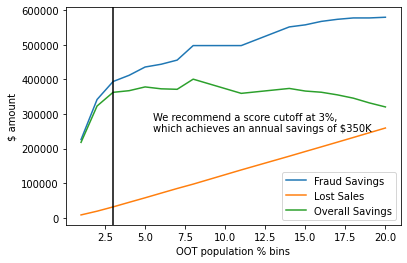

In [264]:
savings.plot(xlabel="OOT population % bins", ylabel="$ amount")
plt.axvline(3, color="black")
plt.text(x=5.5, y=250000, s="We recommend a score cutoff at 3%,\nwhich achieves an annual savings of $350K")
plt.savefig("best_model_savings.png")

## Examples of specific `Cardnum` and `Merchnum`

In [255]:
transactions = pd.read_csv(
    "card transactions.csv",
    usecols=["Amount", "Cardnum", "Merchnum", "Date"],
    parse_dates=["Date"],
    #nrows=10,
)

transactions.head()

,Cardnum,Date,Merchnum,Amount
0,5142190439,2010-01-01,5509006296254,3.62
1,5142183973,2010-01-01,61003026333,31.42
2,5142131721,2010-01-01,4503082993600,178.49
3,5142148452,2010-01-01,5509006296254,3.62
4,5142190439,2010-01-01,5509006296254,3.62


In [256]:
# I am going to randomly pick one of the top-10 mostfrequent
display(transactions["Cardnum"].value_counts(ascending=False).head(300).tail(10))

print("\n")

# I am going to randomly pick one of the top-10 mostfrequent
display(transactions["Merchnum"].value_counts(ascending=False).head(300).tail(10))

5142126921    97
5142227183    96
5142128435    96
5142202814    96
5142123687    96
5142139483    96
5142154377    96
5142111572    95
5142136717    95
5142199109    95
Name: Cardnum, dtype: int64

9108242310006    40
9108242310000    40
465906341338     40
9050153          39
410810006NOT6    39
8098605472612    39
8074000313111    39
490535556        39
4707000531601    39
19909549333      39
Name: Merchnum, dtype: int64

In [257]:
suspect_cardnum, suspect_merchnum = 5142199109, '7539600610006'

In [258]:
IT_preds = clf.predict_proba(IT_z_scaled)[:, 1]
OOT_preds = oot_df["y_pred"].values
all_preds = np.concatenate((IT_preds, OOT_preds), axis=0)

In [259]:
transactions = transactions.iloc[len(transactions)-len(all_preds):]

In [260]:
transactions["fraud_score"] = all_preds

In [262]:
display(
    transactions
    .query("(`Cardnum` == @suspect_cardnum)")
    .sort_values(["Date"], ascending=True)
    .reset_index(drop=True)
)

,Cardnum,Date,Merchnum,Amount,fraud_score
0,5142199109,2010-01-05,5800063100289,152.60,0.006993
1,5142199109,2010-01-07,5800063100289,27.84,0.007591
2,5142199109,2010-01-10,4112000900067,275.00,0.006993
3,5142199109,2010-01-13,600000201284,370.00,0.007385
4,5142199109,2010-02-03,6129665000520,221.00,0.006993
5,5142199109,2010-02-09,8100544006802,460.00,0.006993
6,5142199109,2010-02-10,975678100226,144.86,0.008016
7,5142199109,2010-02-28,4353000719908,41.94,0.006993
8,5142199109,2010-03-07,467900780332,554.90,0.006993
9,5142199109,2010-03-08,600020018966,200.00,0.006993


In [261]:
display(
    transactions
    .query("(`Merchnum` == @suspect_merchnum)")
    .sort_values(["Date"], ascending=True)
    .reset_index(drop=True)
)

,Cardnum,Date,Merchnum,Amount,fraud_score
0,5142154098,2010-01-14,7539600610006,601.21,0.006993
1,5142153880,2010-01-14,7539600610006,1005.75,0.008016
2,5142154098,2010-01-14,7539600610006,225.00,0.006993
3,5142154098,2010-02-14,7539600610006,146.29,0.006993
4,5142154098,2010-03-07,7539600610006,601.21,0.006993
5,5142154098,2010-03-07,7539600610006,225.00,0.006993
6,5142154098,2010-03-07,7539600610006,131.88,0.006993
7,5142154098,2010-04-04,7539600610006,426.00,0.006993
8,5142154098,2010-04-18,7539600610006,225.00,0.006993
9,5142154098,2010-04-18,7539600610006,601.21,0.007304


For both the card and merchant numbers examined, the fraud score tends to spike when there are multiple transactions between the same card and merchant on the same day.

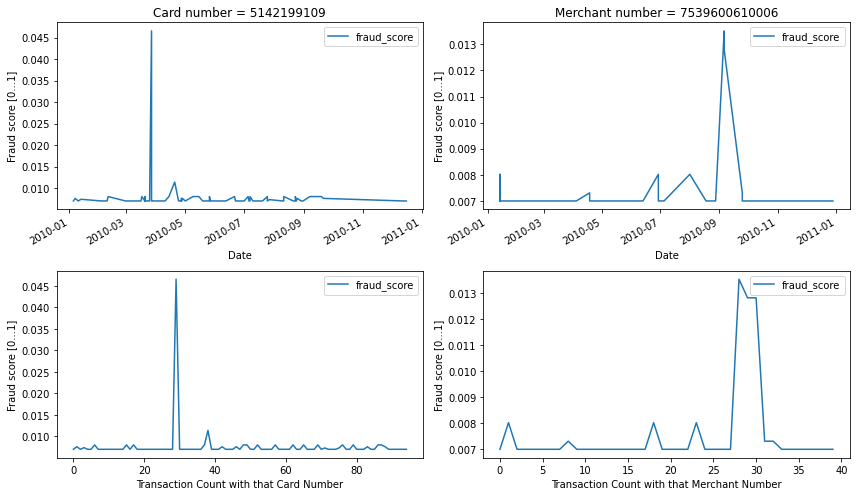

In [238]:
fig, axes = plt.subplots(2, 2, tight_layout=True, figsize=(12, 7))

(
    transactions
    .query("`Cardnum` == @suspect_cardnum")
    .plot(x="Date", y="fraud_score", ax=axes[0, 0], title=f"Card number = {suspect_cardnum}")
)

(
    transactions
    .query("`Cardnum` == @suspect_cardnum")
    .reset_index(drop=True)
    .plot(y="fraud_score", ax=axes[1, 0], xlabel="Transaction Count with that Card Number")
)
    
(
    transactions
    .query("`Merchnum` == @suspect_merchnum")
    .plot(x="Date", y="fraud_score", ax=axes[0, 1], title=f"Merchant number = {suspect_merchnum}")
)
    

(
    transactions
    .query("`Merchnum` == @suspect_merchnum")
    .reset_index(drop=True)
    .plot(y="fraud_score", ax=axes[1, 1], xlabel="Transaction Count with that Merchant Number")
)

for ax in axes.ravel():
    ax.set_ylabel("Fraud score [0...1]")
    
fig.savefig("best_model_specific_cardnum_merchnum.png")